In [2]:
import pandas as pd
from lib.preprocessing import *
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
# %matplotlib inline
# import missingno as msno

In [3]:
df = load_sample(percentage=1, csv_file="data/train_full.csv")
df

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_1205,User_Id_867,Bike,3,Business,12,2,2:09:36 PM,12,2,...,2:49:32 PM,10,27.2,NaN,-1.299144,36.752880,-1.263818,36.793006,Rider_Id_24,1216
1,Order_No_6232,User_Id_2523,Bike,3,Business,17,5,1:31:52 PM,17,5,...,2:08:21 PM,4,NaN,NaN,-1.255189,36.782203,-1.275434,36.812716,Rider_Id_147,680
2,Order_No_11878,User_Id_2330,Bike,3,Business,28,1,5:36:43 PM,28,1,...,6:35:16 PM,4,25.3,NaN,-1.293082,36.827858,-1.291525,36.805576,Rider_Id_206,1061
3,Order_No_6104,User_Id_2200,Bike,3,Business,13,3,12:47:58 PM,13,3,...,1:38:56 PM,4,19.9,NaN,-1.276574,36.851365,-1.290894,36.822971,Rider_Id_444,883
4,Order_No_19885,User_Id_1839,Bike,3,Personal,11,1,10:50:55 AM,11,1,...,11:12:15 AM,11,26.6,NaN,-1.296310,36.768822,-1.331405,36.822937,Rider_Id_345,969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Order_No_4021,User_Id_2330,Bike,3,Business,16,3,11:37:02 AM,16,3,...,11:59:26 AM,9,22.6,NaN,-1.304081,36.792422,-1.264290,36.800214,Rider_Id_253,1222
21197,Order_No_487,User_Id_2587,Bike,3,Business,26,5,10:22:02 AM,26,5,...,11:19:08 AM,7,NaN,NaN,-1.288780,36.816831,-1.255189,36.782203,Rider_Id_171,1331
21198,Order_No_13501,User_Id_1271,Bike,3,Business,21,4,9:45:13 AM,21,4,...,11:00:08 AM,15,21.7,NaN,-1.324488,36.897792,-1.286473,36.823994,Rider_Id_26,2926
21199,Order_No_7570,User_Id_3426,Bike,3,Business,9,5,4:25:40 PM,9,5,...,5:42:01 PM,11,24.9,NaN,-1.258414,36.804800,-1.302583,36.767081,Rider_Id_40,2373


In [4]:
df.drop(columns="Precipitation in millimeters", inplace=True)
df.head(3)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_1205,User_Id_867,Bike,3,Business,12,2,2:09:36 PM,12,2,...,2,2:49:32 PM,10,27.2,-1.299144,36.752880,-1.263818,36.793006,Rider_Id_24,1216
1,Order_No_6232,User_Id_2523,Bike,3,Business,17,5,1:31:52 PM,17,5,...,5,2:08:21 PM,4,NaN,-1.255189,36.782203,-1.275434,36.812716,Rider_Id_147,680
2,Order_No_11878,User_Id_2330,Bike,3,Business,28,1,5:36:43 PM,28,1,...,1,6:35:16 PM,4,25.3,-1.293082,36.827858,-1.291525,36.805576,Rider_Id_206,1061


In [5]:
# df = df[[
#     "Time from Pickup to Arrival", 
#     "Arrival at Destination - Day of Month", 
#     "Arrival at Destination - Weekday (Mo = 1)", 
#     "Arrival at Destination - Time",
#     "Pickup - Day of Month",
#     "Pickup - Weekday (Mo = 1)",
#     "Pickup - Time",
#     "Arrival at Pickup - Day of Month",
#     'Arrival at Pickup - Weekday (Mo = 1)', 
#     "Arrival at Pickup - Time",
#     "Confirmation - Day of Month",
#     'Confirmation - Weekday (Mo = 1)', 
#     'Confirmation - Time',
#     "Placement - Day of Month",
#     'Placement - Weekday (Mo = 1)', 
#     'Placement - Time',
#     "Temperature"
# ]]
# df.head(3)

In [6]:
pd.to_timedelta(df['Time from Pickup to Arrival'].max())

Timedelta('0 days 00:00:00.000007883')

In [7]:
# df['Time from Pickup to Arrival'] = pd.to_timedelta(df['Time from Pickup to Arrival'], unit="sec")
# df.head(3)

In [8]:
(df["Arrival at Destination - Day of Month"] < df['Pickup - Day of Month']).sum()
# this being 0 means that there are no data points that cross over into the next month (so a date time where everything is Jan 1969 is OK)

0

In [9]:
(df["Arrival at Destination - Day of Month"] > df['Pickup - Day of Month']).sum()
# this also being zero means that no delivery was picked up on the day before it arrived

0

In [10]:
df["Arrival at Destination - Day of Month"].describe()

count    21201.000000
mean        15.653837
std          8.798886
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         31.000000
Name: Arrival at Destination - Day of Month, dtype: float64

In [11]:
(df['Arrival at Pickup - Day of Month'] > df["Pickup - Day of Month"]).sum() + \
(df['Arrival at Pickup - Day of Month'] < df["Pickup - Day of Month"]).sum()

0

In [12]:
(df['Arrival at Pickup - Day of Month'] > df["Confirmation - Day of Month"]).sum() + \
(df['Arrival at Pickup - Day of Month'] < df["Confirmation - Day of Month"]).sum()

0

In [13]:
(df['Placement - Day of Month'] > df["Confirmation - Day of Month"]).sum()

0

In [14]:
(df['Placement - Day of Month'] < df["Confirmation - Day of Month"]).sum()

2

In [15]:
df.loc[(df['Placement - Day of Month'] < df["Confirmation - Day of Month"])]

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
11378,Order_No_3530,User_Id_2457,Bike,3,Business,11,2,12:22:05 PM,13,4,...,4,2:24:41 PM,8,22.5,-1.291548,36.829752,-1.255189,36.782203,Rider_Id_247,1854
17533,Order_No_2800,User_Id_1402,Bike,3,Business,17,1,2:34:37 PM,18,2,...,2,2:45:52 PM,11,25.6,-1.225322,36.808550,-1.281754,36.832423,Rider_Id_928,2640


In [16]:
fulfillment_weekday = df['Arrival at Destination - Weekday (Mo = 1)'] % 7
fulfillment_month_day = df['Arrival at Destination - Day of Month']

In [17]:
df['Fulfillment - Weekday (Su = 0)'] = fulfillment_weekday
df['Fulfillment - Day of Month'] = fulfillment_month_day

In [18]:
df.drop(
    columns=[
        'Arrival at Destination - Weekday (Mo = 1)', 
        'Arrival at Destination - Day of Month',
        'Arrival at Destination - Time',
        'Pickup - Weekday (Mo = 1)',
        'Pickup - Day of Month',
        'Arrival at Pickup - Weekday (Mo = 1)',
        'Arrival at Pickup - Day of Month',
        'Confirmation - Weekday (Mo = 1)',
        'Confirmation - Day of Month'  
    ],
    inplace=True
)
df.head(3)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,...,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,Fulfillment - Weekday (Su = 0),Fulfillment - Day of Month
0,Order_No_1205,User_Id_867,Bike,3,Business,12,2,2:09:36 PM,2:10:13 PM,2:24:55 PM,...,10,27.2,-1.299144,36.752880,-1.263818,36.793006,Rider_Id_24,1216,2,12
1,Order_No_6232,User_Id_2523,Bike,3,Business,17,5,1:31:52 PM,1:34:06 PM,1:40:39 PM,...,4,NaN,-1.255189,36.782203,-1.275434,36.812716,Rider_Id_147,680,5,17
2,Order_No_11878,User_Id_2330,Bike,3,Business,28,1,5:36:43 PM,5:41:01 PM,6:13:04 PM,...,4,25.3,-1.293082,36.827858,-1.291525,36.805576,Rider_Id_206,1061,1,28


In [19]:
save_data(df, sql_db="data/cleaned_nelson_no_temp.db")

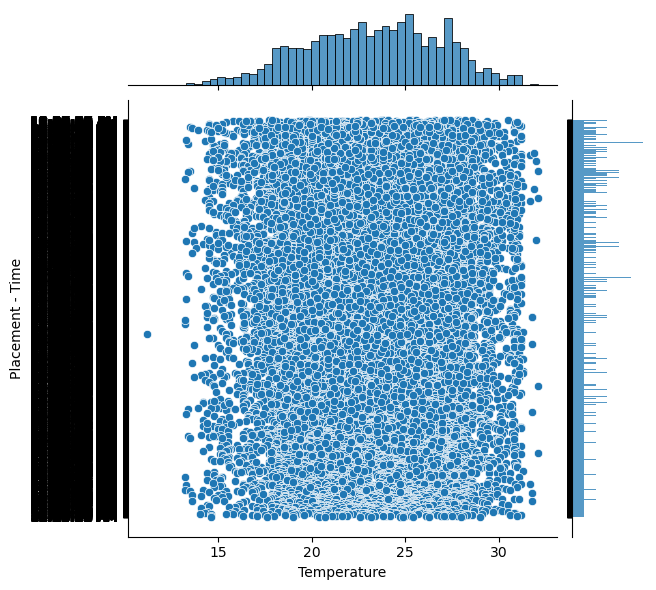

In [21]:
# df['delivery_time'] = df['Time from Pickup to Arrival'].dt.seconds
sns.jointplot(df, x="Temperature", y="Placement - Time")

In [79]:
temp_control = df[[
    "Placement - Day of Month", 
    "Placement - Weekday (Mo = 1)", 
    "Placement - Time", 
    "Pickup Long", 
    "Pickup Lat",
    "Destination Long",
    "Destination Lat",
    "Distance (KM)",
    "Time from Pickup to Arrival",
    "Temperature"
]]
def get_minute_from_dt_series(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series).dt.hour * 60 + pd.to_datetime(series).dt.minute

temp_control["Placement - Time"] = get_minute_from_dt_series(temp_control["Placement - Time"])
temp_control.head(3)

/tmp/ipykernel_4490/173024038.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_control["Placement - Time"] = get_minute_from_dt_series(temp_control["Placement - Time"])


,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Pickup Long,Pickup Lat,Destination Long,Destination Lat,Distance (KM),Time from Pickup to Arrival,Temperature
0,12,2,849,36.752880,-1.299144,36.793006,-1.263818,10,1216,27.2
1,17,5,811,36.782203,-1.255189,36.812716,-1.275434,4,680,NaN
2,28,1,1056,36.827858,-1.293082,36.805576,-1.291525,4,1061,25.3


In [81]:
imputer = IterativeImputer(random_state=42)
imputer.fit(temp_control.to_numpy())
df['Temperature'] = imputer.transform(temp_control)[:, -1]
del imputer

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(


In [82]:
df

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,...,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,Fulfillment - Weekday (Su = 0),Fulfillment - Day of Month
0,Order_No_1205,User_Id_867,Bike,3,Business,12,2,2:09:36 PM,2:10:13 PM,2:24:55 PM,...,10,27.200000,-1.299144,36.752880,-1.263818,36.793006,Rider_Id_24,1216,2,12
1,Order_No_6232,User_Id_2523,Bike,3,Business,17,5,1:31:52 PM,1:34:06 PM,1:40:39 PM,...,4,23.673476,-1.255189,36.782203,-1.275434,36.812716,Rider_Id_147,680,5,17
2,Order_No_11878,User_Id_2330,Bike,3,Business,28,1,5:36:43 PM,5:41:01 PM,6:13:04 PM,...,4,25.300000,-1.293082,36.827858,-1.291525,36.805576,Rider_Id_206,1061,1,28
3,Order_No_6104,User_Id_2200,Bike,3,Business,13,3,12:47:58 PM,1:14:51 PM,1:22:32 PM,...,4,19.900000,-1.276574,36.851365,-1.290894,36.822971,Rider_Id_444,883,3,13
4,Order_No_19885,User_Id_1839,Bike,3,Personal,11,1,10:50:55 AM,10:51:08 AM,10:51:42 AM,...,11,26.600000,-1.296310,36.768822,-1.331405,36.822937,Rider_Id_345,969,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Order_No_4021,User_Id_2330,Bike,3,Business,16,3,11:37:02 AM,11:37:08 AM,11:37:22 AM,...,9,22.600000,-1.304081,36.792422,-1.264290,36.800214,Rider_Id_253,1222,3,16
21197,Order_No_487,User_Id_2587,Bike,3,Business,26,5,10:22:02 AM,10:35:56 AM,10:48:33 AM,...,7,21.879965,-1.288780,36.816831,-1.255189,36.782203,Rider_Id_171,1331,5,26
21198,Order_No_13501,User_Id_1271,Bike,3,Business,21,4,9:45:13 AM,9:45:54 AM,10:01:26 AM,...,15,21.700000,-1.324488,36.897792,-1.286473,36.823994,Rider_Id_26,2926,4,21
21199,Order_No_7570,User_Id_3426,Bike,3,Business,9,5,4:25:40 PM,4:28:20 PM,4:56:09 PM,...,11,24.900000,-1.258414,36.804800,-1.302583,36.767081,Rider_Id_40,2373,5,9


In [83]:
save_data(df, sql_db="data/cleaned_nelson.db")

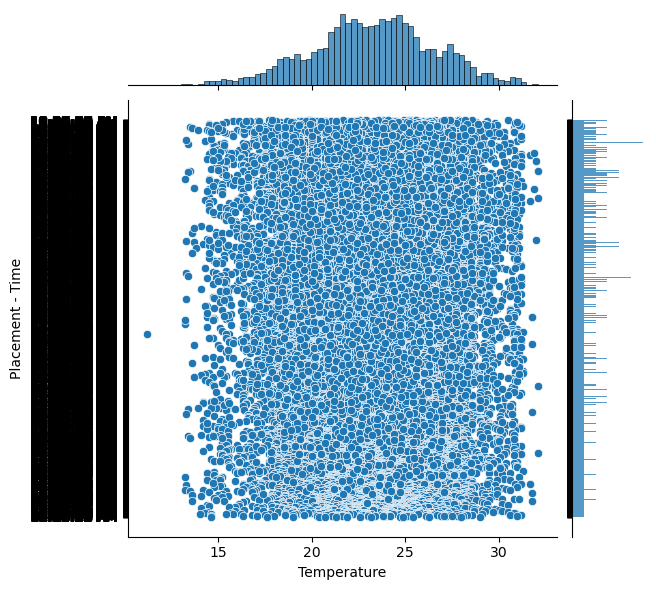

In [84]:
sns.jointplot(df, x="Temperature", y="Placement - Time")

In [ ]:
raise Exception()
weekdays = (df['Arrival at Destination - Weekday (Mo = 1)'] % 7)
weekdays.unique()

Exception: 

0         21-4 1:48:39 PM
1         15-6 9:37:15 AM
2         21-3 5:00:08 PM
3        13-4 10:32:50 AM
4         19-3 4:20:05 PM
               ...       
21196     17-4 8:53:35 AM
21197     7-6 12:27:24 PM
21198     18-1 3:25:02 PM
21199     28-1 1:35:04 PM
21200     13-2 2:48:53 PM
Length: 21201, dtype: object

In [ ]:
pd.to_datetime(
    df['Arrival at Destination - Day of Month'].astype(str) + "-" \
        + weekdays.astype(str) + " " \
        + df['Arrival at Destination - Time'],
    format='%d-%w %I:%M:%S %p').iloc[0].day_of_week

6

In [ ]:
weekdays.iloc[0]

4

In [ ]:
pickup_time = "1969-01-" + df['Pickup - Day of Month'].astype(str) + " " + df["Pickup - Time"].astype(str)
pickup_time

0         1969-01-21 1:06:24 PM
1         1969-01-15 9:37:05 AM
2         1969-01-21 4:35:44 PM
3        1969-01-13 10:10:15 AM
4         1969-01-19 3:06:30 PM
                  ...          
21196     1969-01-17 8:41:33 AM
21197     1969-01-7 12:10:23 PM
21198     1969-01-18 2:37:34 PM
21199     1969-01-28 1:22:54 PM
21200     1969-01-13 2:34:25 PM
Length: 21201, dtype: object

In [ ]:
df['Pickup'] = pd.to_datetime(pickup_time)
df['Pickup']

/tmp/ipykernel_13524/109605495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pickup'] = pd.to_datetime(pickup_time)


0       1969-01-21 13:06:24
1       1969-01-15 09:37:05
2       1969-01-21 16:35:44
3       1969-01-13 10:10:15
4       1969-01-19 15:06:30
                ...        
21196   1969-01-17 08:41:33
21197   1969-01-07 12:10:23
21198   1969-01-18 14:37:34
21199   1969-01-28 13:22:54
21200   1969-01-13 14:34:25
Name: Pickup, Length: 21201, dtype: datetime64[ns]

In [ ]:
df.head(3).drop(columns=["Pickup - Day of Month", "Pickup - Time"])

,Time from Pickup to Arrival,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Pickup - Weekday (Mo = 1),Temperature,Pickup
0,0 days 00:42:15,21,4,1:48:39 PM,4,25.4,1969-01-21 13:06:24
1,0 days 00:00:10,15,6,9:37:15 AM,6,17.4,1969-01-15 09:37:05
2,0 days 00:24:24,21,3,5:00:08 PM,3,NaN,1969-01-21 16:35:44


In [ ]:
df['Arrival at Destination'] = pd.to_datetime()

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

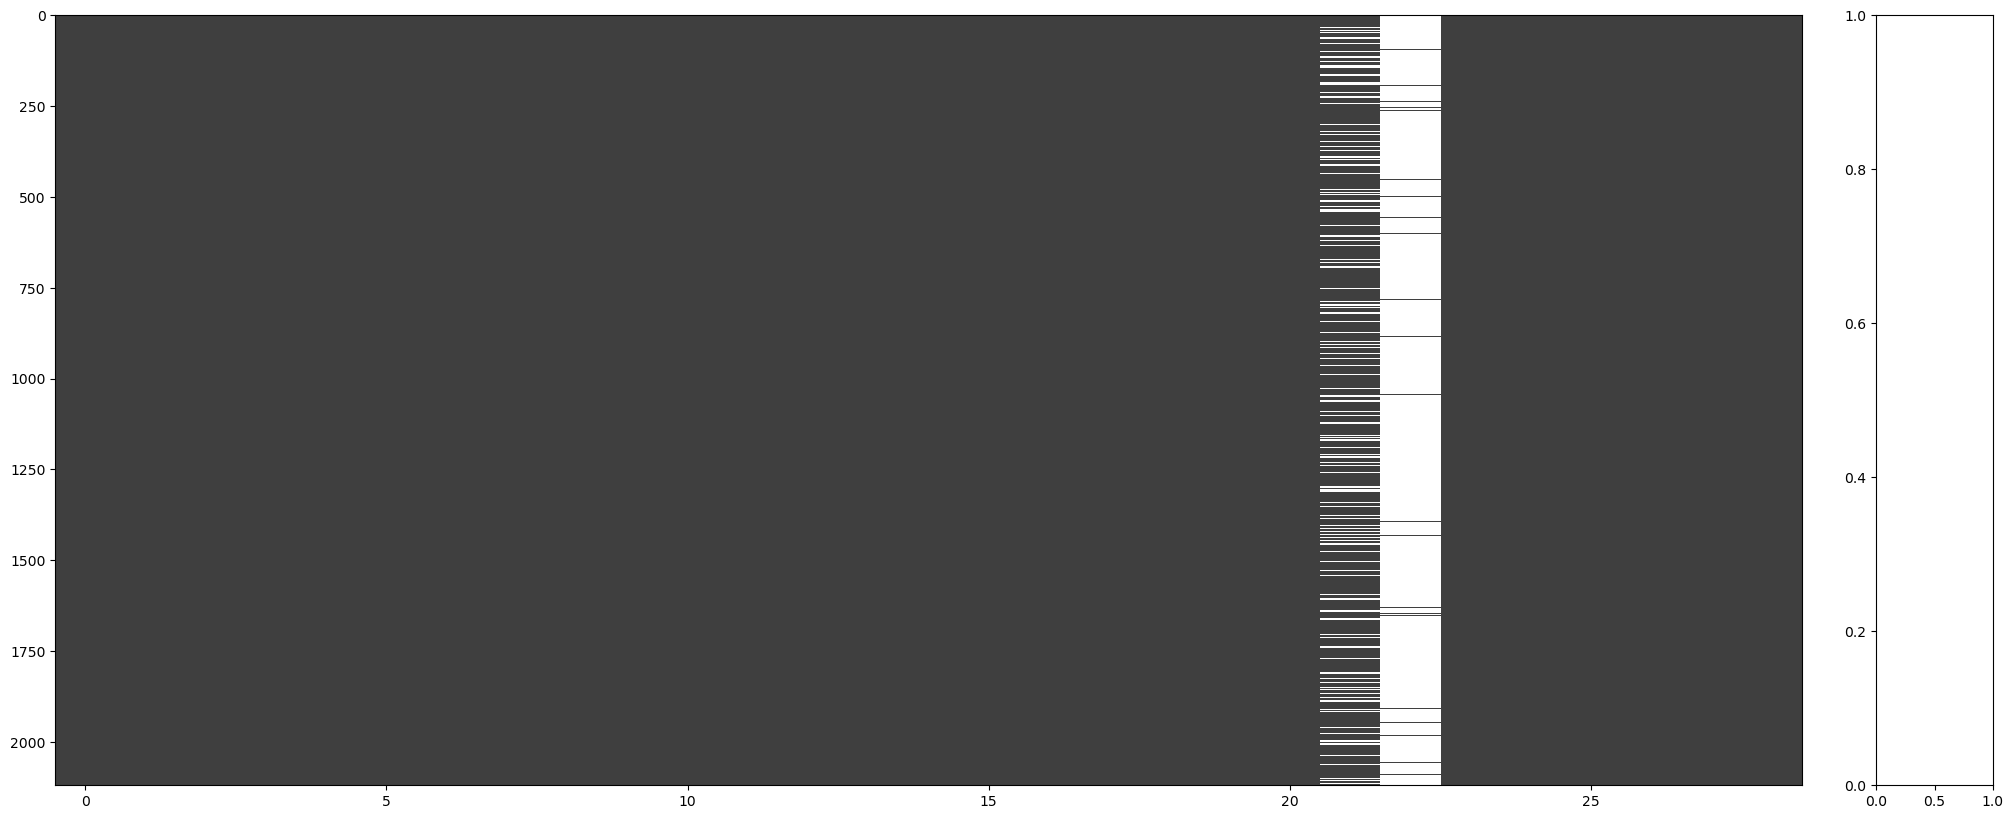

In [ ]:
msno.matrix(df)

In [ ]:
# seems like column index 22 is empty?
print(f"Empty column: {pd.Series(df.columns).iloc[22]}")
print(f"Half empty column: {pd.Series(df.columns).iloc[21]}")

Empty column: Precipitation in millimeters
Half empty column: Temperature


In [ ]:
df['Temperature'].isna().sum() / len(df['Temperature'])

0.19952830188679246

In [ ]:
df.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [ ]:
df = df.drop(columns=["Precipitation in millimeters"])

In [ ]:
df.head(3)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_21092,User_Id_384,Bike,1,Personal,24,4,2:50:22 PM,24,4,...,3:17:24 PM,4,22.8,NaN,-1.299029,36.782493,-1.276549,36.766981,Rider_Id_761,739
1,Order_No_3234,User_Id_1329,Bike,3,Business,12,3,3:25:33 PM,12,3,...,4:20:32 PM,4,20.8,NaN,-1.273056,36.811298,-1.285445,36.818836,Rider_Id_291,693
2,Order_No_10462,User_Id_1020,Bike,1,Personal,2,4,2:47:17 PM,2,4,...,3:37:02 PM,7,26.2,NaN,-1.276479,36.819479,-1.312942,36.815265,Rider_Id_754,1143


In [ ]:
save_data(df, sql_db="data/saved.db")

In [ ]:
cols = pd.Series(df.columns.format())

weekday = cols.loc[cols.str.match(".*Mo = 1.*")] # 5 of these
metrics = ["Temperature", "Precipitation in millimeters", "Distance (KM)"]  # 3 of these

ids = pd.concat([cols.loc[cols.str.match(".*Id.*")], cols.loc[cols.str.match(".*No.*")]]) # 3 of these
month_days = cols.loc[cols.str.match(".*Day of Month.*")] # 5 of these

location = ["Pickup Lat", "Pickup Long", "Destination Lat", "Destination Long"] # 4 of these
times = cols.loc[cols.str.match(".*Time.*")] # 6(actually 4) of these

types = ["Vehicle Type", "Platform Type", "Personal or Business", ] # 3 of these


In [ ]:
ids

1      User Id
27    Rider Id
0     Order No
dtype: object

In [ ]:
df[["Arrival at Pickup - Time", "Pickup - Time"]]

In [ ]:
desc = pd.read_csv("variable_definitions.csv")
desc

,Variable Name,Description
0,Order No,Unique number identifying the order
1,User Id,Unique number identifying the customer on a pl...
2,Vehicle Type,"For this competition limited to bikes, however..."
3,Platform Type,"Platform used to place the order, there are 4 ..."
4,Personal or Business,Customer type
5,Placement - Day of Month,Placement - Day of Month i.e 1-31
6,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
7,Placement - Time,Placement - Time - Time of day the order was p...
8,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
9,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [ ]:
df['Rider Id']

0       Rider_Id_761
1       Rider_Id_291
2       Rider_Id_754
3       Rider_Id_183
4       Rider_Id_931
            ...     
2115    Rider_Id_449
2116    Rider_Id_395
2117    Rider_Id_446
2118    Rider_Id_906
2119    Rider_Id_882
Name: Rider Id, Length: 2120, dtype: object

In [ ]:
df['Platform Type'].unique()

array([1, 3, 2, 4])